In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
kagip = '/kaggle/input/'
datasets = []
# for filenames in os.listdir(path='/kaggle/input'):
#     print('----', filenames)
#     for f in os.listdir(kagip+filenames):
#         datasets.append(os.path.join(filenames,f))
#         print(datasets[-1])

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Setting GPUs

In [2]:
import tensorflow as tf
import os
gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Data Loading as batches and Augmentation

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
root_dir = './'
train_data_dir = validation_data_dir = test_data_dir = None


train_data_dir = f'{root_dir}train/'
# validation_data_dir = f'{root_dir}/intel-image/val'
# test_data_dir = f'{root_dir}/intel-image/val'

def get_data(ims=150, batch_size=32):
    
    augdict = {
        'rotation_range':20,
        'width_shift_range':0.2,
        'height_shift_range':0.2,
        'shear_range':0.2,
        'zoom_range':0.2,
        'horizontal_flip':True,
        'fill_mode':'nearest',
    }

    split = 0.2

    datagen = ImageDataGenerator(
    #     rescale=1.0 / 255,
        # **augdict,
        validation_split=split
    )

    auggen = ImageDataGenerator(
    #     rescale=1.0 / 255,
        **augdict,
        validation_split=split
    )

    valgen = ImageDataGenerator(
    #     rescale=1.0 / 255,
        # **augdict,
        validation_split=split
    )
    testgen = ImageDataGenerator(
    #     rescale=1.0 / 255,
        # **augdict,
    )


    print(end='data_generator:\t')
    data_generator = None
    data_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(ims, ims),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',  # Specify 'training' or 'validation'
        shuffle=True
    )
    
    print(end='aug_generator:\t')
    aug_generator = None
    aug_generator = auggen.flow_from_directory(
        train_data_dir,
        target_size=(ims, ims),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',  # Specify 'training' or 'validation'
        shuffle=True
    )

    print(end='val_generator:\t')
    val_generator = None
    val_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(ims, ims),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',  # Specify 'training' or 'validation'
        shuffle=False
    )

    test_generator = None
    if test_data_dir:
        print(end='test_generator:\t')
        test_generator = testgen.flow_from_directory(
            test_data_dir,
            target_size=(ims, ims),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )

    num_classes, nb_train_samples, nb_validation_samples = val_generator.num_classes, len(data_generator.classes), len(val_generator.classes)
    return data_generator, aug_generator, val_generator, test_generator, ims, batch_size, num_classes, nb_train_samples, nb_validation_samples


data_generator, aug_generator, val_generator, test_generator, ims, batch_size, num_classes, nb_train_samples, nb_validation_samples = get_data(224, 32)
# nb_train_samples, nb_validation_samples

data_generator:	Found 2613 images belonging to 4 classes.
aug_generator:	Found 2613 images belonging to 4 classes.
val_generator:	Found 652 images belonging to 4 classes.


# Performance functions
* `plot_multi_loss_acc(histories)`
* `print_f1_acc(model, dataset)`
* `print_multi_f1_acc(models, dataset)`
* `get_np_array_from_gen(generator, num)`
* `print_layers_of_model(model)`
* `get_class_weights(generator)`
* `callbacks`

In [4]:
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight

def plot_multi_loss_acc(histories):
    fig = plt.figure(figsize=(12,7))
    for i,hist in enumerate(histories):
        keys = list(hist.history.keys())
        plt.subplot(1,2,1)
        plt.plot(hist.history[keys[0]], label=f'loss{i+1}', linestyle='--') # color = 'orange'
        plt.plot(hist.history[keys[2]], label=f'v_loss{i+1}') # color = 'orange'
        plt.title('Loss', fontsize=20)
        plt.legend(loc="upper right")
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(hist.history[keys[1]], label=f'acc{i+1}', linestyle='--') # color = 'orange'
        plt.plot(hist.history[keys[3]], label=f'v_acc{i+1}') # color = 'orange'
        plt.title('Accuracy', fontsize=20)
        plt.legend(loc="lower right")
        plt.grid(True)
        
        plt.tight_layout()
    plt.show()
    return fig
    
    
def print_f1_acc(model, dataset):
    true_labels = np.array(dataset.classes)
    predictions = model.predict(dataset)
    pred_labels = predictions.argmax(axis=1)
    f1 = f1_score(true_labels, pred_labels, average='macro')
    acc = accuracy_score(true_labels, pred_labels)
    print(f"Accuracy = \t{acc*100}%\nF1-score = \t{f1}")
    return f1, acc


def print_multi_f1_acc(models, dataset):
    true_labels = np.array(dataset.classes)
    all_predictions = []
    for i,model in enumerate(models):
        print(f'\nModel: {i+1}')
        predictions = model.predict(dataset)
        all_predictions.append(predictions)
        pred_labels = predictions.argmax(axis=1)
        f1 = f1_score(true_labels, pred_labels, average='macro')
        acc = accuracy_score(true_labels, pred_labels)
        print(f"Accuracy = \t{acc*100}%\nF1-score = \t{f1}")
        all_predictions.append(predictions)
    predictions = np.array(all_predictions)
    predictions = predictions.sum(axis = 0)
    pred_labels = predictions.argmax(axis=1)
    f1 = f1_score(true_labels, pred_labels, average='macro')
    acc = accuracy_score(true_labels, pred_labels)
    print(f"\n{'-'*30}\nFinal Ensemble:\nAccuracy = \t{acc*100}%\nF1-score = \t{f1}")
    return f1, acc
    
def get_np_array_from_gen(generator, num):
    X = []
    y = []
    for b in generator:
        X.extend(b[0])
        y.extend(b[1])
        if len(X)>=num: break
    return np.array(X), np.array(y)

def print_layers_of_model(model):
    for i,layer in enumerate(model.layers):
        print(i+1, layer.name)

def get_class_weights(generator):
    class_weights = compute_class_weight('balanced', classes=np.unique(generator.classes), y=generator.classes)
    class_weights = dict((k,v) for k,v in enumerate(class_weights))
    return class_weights



# callbacks
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
checkpoint = tf.keras.callbacks.ModelCheckpoint("effnet.h5",monitor="val_categorical_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_categorical_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=7,
    min_delta=0.001,
    restore_best_weights=True,
)

# print(get_class_weights(train_generator))
# plt.hist(train_generator.classes)

# EDA

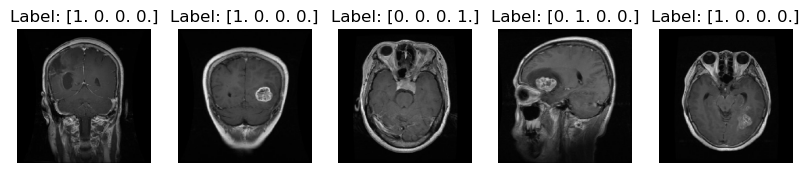

In [5]:
import matplotlib.pyplot as plt

# Print a few generated images for visualization
num_samples_to_display = 5

# Get a batch of images and labels from the data generator
images, labels = next(data_generator)

# Display the images and their labels
plt.figure(figsize=(10, 10))
for i in range(num_samples_to_display):
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(images[i]/255)
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
[0 1 2 3] [741 750 401 721]


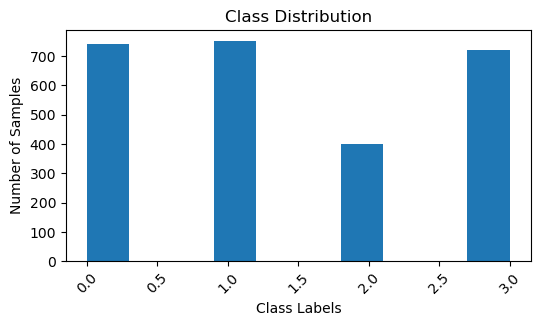

In [6]:
print(data_generator.class_indices)
class_labels = data_generator.classes
unique_classes, class_counts = np.unique(class_labels, return_counts=True)
print(unique_classes, class_counts)
plt.figure(figsize=(6, 3))
plt.hist( data_generator.classes)#, bins=num_classes)
plt.title('Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
# plt.grid(True)
plt.show()

# Fitting to Models
### All packages

In [13]:
import random
import tensorflow as tf
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers.experimental import preprocessing

### Some pre-trained models to test

* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* DenseNet121
* EfficientNet
    * EfficientNetB0 - (224, 224, 3)
    * EfficientNetB1 - (240, 240, 3)
    * EfficientNetB2 - (260, 260, 3)
    * EfficientNetB3 - (300, 300, 3)
    * EfficientNetB4 - (380, 380, 3)
    * EfficientNetB5 - (456, 456, 3)
    * EfficientNetB6 - (528, 528, 3)
    * EfficientNetB7 - (600, 600, 3)

### EfficientNet

In [14]:
# path to the model weights files.
# root_dir = '/Users/jijnasu/Workspace/OD-WeaponDetection'
root_dir = '/kaggle/working/'

try:
    os.mkdir(f'{root_dir}/models/')
    print('models created')
except:
    pass
try:
    os.mkdir(f'{root_dir}/models/new_way/')
    print('models/new_way created')
except:
    pass
try:
    os.mkdir(f'{root_dir}/models/old_way/')
    print('models/old_way created')
except:
    pass

ims = 260
# Data Loading
data_generator, aug_generator, val_generator, test_generator, ims, batch_size, num_classes, nb_train_samples, nb_validation_samples = get_data(ims, 32)

model_name = 'EfficientNetB2'
# ims = ims
img_width, img_height = ims, ims

# train_data_dir = f'{root_dir}/Knife classification/'
# validation_data_dir = f'{root_dir}/intel-image/val'
# nb_train_samples = batch_size
# nb_validation_samples = batch_size
# epochs = 3
# batch_size = batch_size
models_dir = f'{root_dir}/models/new_way/'
# bottlenech_model_weights_path = f'{models_dir}{model_name}_{nb_train_samples}_bottleneck_fc_model.h5'
top_trained_model_weights_path = f'{models_dir}{model_name}_{nb_train_samples}_top_trained_fc_model.h5'
fine_tuned_model_weights_path = f'{models_dir}{model_name}_{nb_train_samples}_fine_tuned_fc_model.h5'



from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    data_augmentation = tf.keras.Sequential([
        layers.RandomCrop(height=224, width=224),      
        layers.RandomFlip("horizontal_and_vertical"),  
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  
        layers.RandomRotation(factor=0.2),              
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),  
        layers.RandomContrast(factor=0.2),              
        layers.RandomBrightness(factor=0.2)             
    ])

    base_model = keras.applications.EfficientNetB2(
        weights="imagenet",
        input_shape=(ims, ims, 3),
        include_top=False,
    )

    # Freeze the base_model
    # base_model.trainable = False

    # scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    # scale_layer = tf.keras.applications.resnet.preprocess_input


    # Create new model on top
    x = inputs = keras.Input(shape=(ims, ims, 3))
    # x = data_augmentation(inputs)
    # x = scale_layer(x)
    x = base_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    # x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    # x = keras.layers.Dense(256, activation='relu')(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)



#     model = Sequential()
#     model.add(base_model)
#     model.add(GlobalAveragePooling2D())
# #     model.add(Dense(900, activation='relu', kernel_regularizer=l2(0.001)))
#     model.add(Dropout(0.5))
# #     model.add(Dense(200, activation='relu'))#, kernel_regularizer=l2(0.001)))
#     model.add(Dense(num_classes, activation='softmax'))



    print(model.summary())

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.CategoricalAccuracy()],
    )

    epochs = 100
    generator = aug_generator
    history = model.fit(
                generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs, 
                validation_data=val_generator,
                validation_steps=nb_validation_samples//batch_size,
                callbacks=[early_stopping, reduce_lr]
            )
    model.save_weights(top_trained_model_weights_path)

models created
models/new_way created
models/old_way created
data_generator:	Found 2613 images belonging to 4 classes.
aug_generator:	Found 2613 images belonging to 4 classes.
val_generator:	Found 652 images belonging to 4 classes.


NameError: name 'fds' is not defined

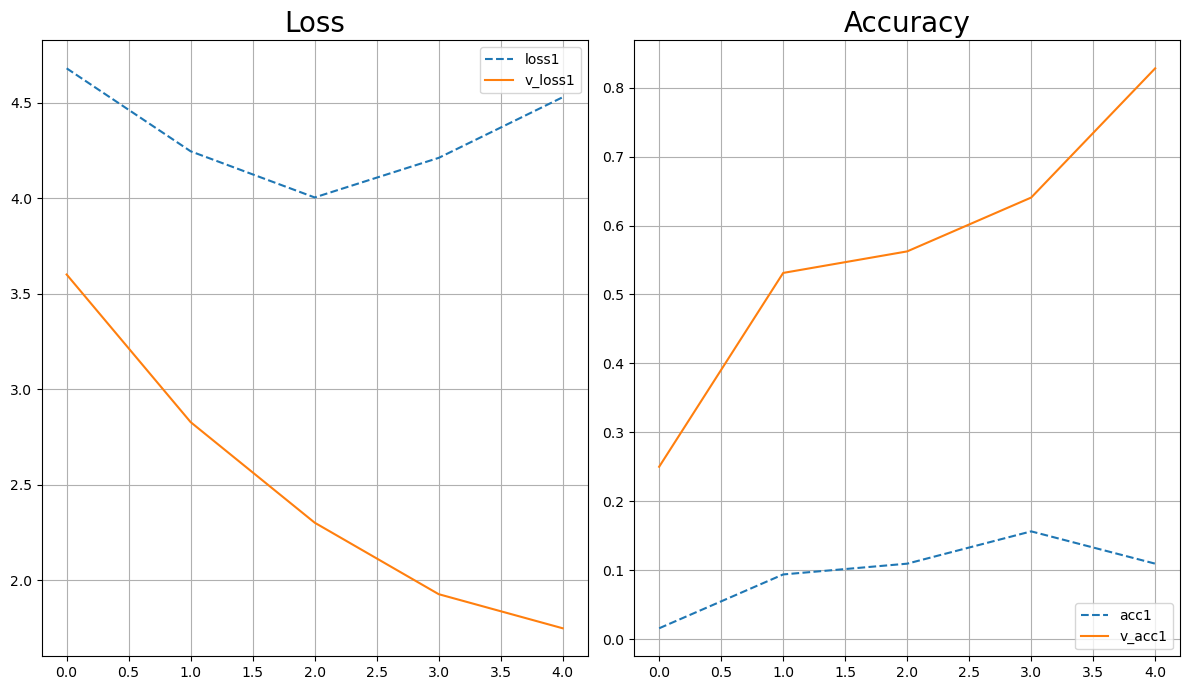

In [29]:
fig = plot_multi_loss_acc([history])

In [31]:
print_f1_acc(model, val_generator)

2023-09-15 15:10:49.140872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


 2/62 [..............................] - ETA: 6s   

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


 3/62 [>.............................] - ETA: 31s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


 4/62 [>.............................] - ETA: 40s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


 5/62 [=>............................] - ETA: 42s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


 6/62 [=>............................] - ETA: 43s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


 7/62 [==>...........................] - ETA: 46s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


 8/62 [==>...........................] - ETA: 46s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


 9/62 [===>..........................] - ETA: 46s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


10/62 [===>..........................] - ETA: 46s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


11/62 [====>.........................] - ETA: 45s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


12/62 [====>.........................] - ETA: 44s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


13/62 [=====>........................] - ETA: 44s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


14/62 [=====>........................] - ETA: 44s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


15/62 [======>.......................] - ETA: 43s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


16/62 [======>.......................] - ETA: 43s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


17/62 [=======>......................] - ETA: 42s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


18/62 [=======>......................] - ETA: 41s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


19/62 [========>.....................] - ETA: 40s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


20/62 [========>.....................] - ETA: 39s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


21/62 [=========>....................] - ETA: 38s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


22/62 [=========>....................] - ETA: 37s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


23/62 [==========>...................] - ETA: 36s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


24/62 [==========>...................] - ETA: 36s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


25/62 [===========>..................] - ETA: 35s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


26/62 [===========>..................] - ETA: 35s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


27/62 [============>.................] - ETA: 34s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


28/62 [============>.................] - ETA: 33s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


29/62 [=============>................] - ETA: 32s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


30/62 [=============>................] - ETA: 31s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


31/62 [==============>...............] - ETA: 30s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


32/62 [==============>...............] - ETA: 29s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


33/62 [==============>...............] - ETA: 28s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


34/62 [===============>..............] - ETA: 27s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


35/62 [===============>..............] - ETA: 26s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


36/62 [================>.............] - ETA: 26s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


37/62 [================>.............] - ETA: 25s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


38/62 [=================>............] - ETA: 24s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


39/62 [=================>............] - ETA: 23s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


40/62 [==================>...........] - ETA: 22s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


41/62 [==================>...........] - ETA: 21s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


42/62 [===================>..........] - ETA: 20s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


43/62 [===================>..........] - ETA: 19s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


44/62 [====================>.........] - ETA: 18s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


45/62 [====================>.........] - ETA: 17s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


46/62 [=====================>........] - ETA: 16s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


47/62 [=====================>........] - ETA: 15s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


48/62 [======================>.......] - ETA: 14s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


49/62 [======================>.......] - ETA: 13s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


50/62 [=======================>......] - ETA: 12s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


51/62 [=======================>......] - ETA: 11s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


52/62 [========================>.....] - ETA: 10s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


53/62 [========================>.....] - ETA: 9s 

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


54/62 [=========================>....] - ETA: 8s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


55/62 [=========================>....] - ETA: 7s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


56/62 [==========================>...] - ETA: 6s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


57/62 [==========================>...] - ETA: 5s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


58/62 [===========================>..] - ETA: 4s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


59/62 [===========================>..] - ETA: 3s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


60/62 [============================>.] - ETA: 2s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


61/62 [============================>.] - ETA: 1s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"
loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


62/62 [==============================] - 83s 1s/step
Accuracy = 	16.82765632943569%
F1-score = 	0.014458683438385404


(0.014458683438385404, 0.1682765632943569)

In [71]:
fine_tuned_model_weights_path = f'{models_dir}{model_name}_{nb_train_samples}_fine_tuned_fc_model.h5'
model.layers[3].trainable = False
model.load_weights(top_trained_model_weights_path)
model.layers[3].trainable = True
model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

epochs = 2
history = model.fit(
            data_generator,
            steps_per_epoch=nb_train_samples//batch_size,
            epochs=epochs, 
            validation_data=val_generator,
            validation_steps=nb_validation_samples//batch_size,
            callbacks=[early_stopping]
        )
model.save_weights(fine_tuned_model_weights_path)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                           

2023-09-15 15:41:46.506741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-15 15:41:47.182443: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_5/sequential_5/random_crop_5/loop_body/cond/pfor/cond/branch_executed/_192


In [36]:
print_f1_acc(model, val_generator)


2023-09-15 15:15:31.787231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


 2/62 [..............................] - ETA: 13s  

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


 3/62 [>.............................] - ETA: 28s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


 4/62 [>.............................] - ETA: 36s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"
loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


 6/62 [=>............................] - ETA: 43s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


 7/62 [==>...........................] - ETA: 44s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


 8/62 [==>...........................] - ETA: 46s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


 9/62 [===>..........................] - ETA: 46s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


10/62 [===>..........................] - ETA: 46s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


11/62 [====>.........................] - ETA: 45s

loc("mps_resize"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0783246a-4091-11ee-8fca-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":180:0)): error: 'anec.resize' op Invalid configuration for the following reasons: Error: Invalid tensor format: "fp32"


KeyboardInterrupt: 

# Web app using Gradio

In [27]:
%load_ext gradio
import gradio as gr

The gradio extension is already loaded. To reload it, use:
  %reload_ext gradio


In [50]:
%%blocks

# import gradio as gr

def greet(name):
    return "dfsg: gweadfasdffd " + name + "!"

with gr.Blocks() as demo:
    gr.Interface(fn=greet, inputs="text", outputs="text")
    
# demo.launch()

In [33]:
demo.close()